This notebook provides access to all data and functions required to reproduce the figures in the manuscript, "Restriction of dietary protein leads to conditioned protein preference and elevated palatability of protein-containing food in rats" by Murphy et al submitted on 26 October 2017.

To run the code the following are required: <br>
(1) Med Associates data files<br>
(2) Metafiles for behavioural data (cas9_metafile.txt) and body weight (cas9bw_metafile.txt)<br>

These files are contained in a .zip file as supplementary material attached to the manuscript or can be downloaded from <a href="http://http://www.mccutcheonlab.com/">www.mccutcheonlab.com</a>.

The code was prepared in Python 3.6 and most libraries should be included in a standard installation (e.g. via Anaconda). The exception is the statistics which require R and associated R-to-Python modules to be installed. To toggle statistics on and off change the variable <b><i>statson</i></b> which is assigned below. This variable is set to False by default so that code blocks that perform statistics will not run.

Any queries should be addressed to Dr James McCutcheon (jem64@le.ac.uk).


In [1]:
# Import required packages

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
import timeit
import random
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import os
import pandas as pd
from scipy import stats

In [2]:
cwd = os.getcwd()
print(cwd)

C:\Users\jaimeHP\Documents\GitHub\murphy-2017


In [3]:
# Uncomment these imports for R statistics
statson = False
if statson == True:
    import rpy2.robjects as ro
    from rpy2.robjects import r, pandas2ri, numpy2ri
    pandas2ri.activate()
    numpy2ri.activate()

## Classes

In [4]:
class Rat(object):
    
    nRats = 0
    nSessions = 0
    
    def __init__(self, data):      
        self.rat = data
        self.sessions = {}
        
        Rat.nRats += 1
                
    def loadsession(self, data, header):
        self.session = 's'+str(data[2]) #should reference column of data with session number
        self.sessions[self.session] = Session(data, header, self.rat, self.session)
       
        Rat.nSessions += 1

In [5]:
class Session(object):
    
    def __init__(self, data, header, rat, session):
        self.hrow = {}
        for idx, col in enumerate(header):
            self.hrow[col] = data[idx]
        self.medfile = datafolder + self.hrow['medfile']
        self.sessioncode = self.hrow['sessioncode']
        self.rat = str(rat)
        self.session = session
        self.bottleA = self.hrow['bottleA']
        self.bottleB = self.hrow['bottleB']
        
        if hasattr(rats[self.rat], 'diet'):
            if rats[self.rat].diet != self.hrow['diet']:
                print('Wrong diet for rat, must be a mistake in metafile')
        else:
            rats[self.rat].diet = self.hrow['diet']
                    
    def extractlicks(self, substance):
        licks = medfilereader(self.medfile,
                                  varsToExtract = sub2var(self, substance),
                                                    remove_var_header = True)
        lickData = lickCalc(licks, burstThreshold=0.5, binsize=120)        
        
        return lickData

    def designatesession(self):
        if self.sessioncode == 'casein1':
            if hasattr(rats[self.rat], 'casein1'):
                print('Casein 1 data already added. Check metafile for duplication.')
            else:
                rats[self.rat].casein1 = self.lickData_cas
                    
        if self.sessioncode == 'casein2':
            if hasattr(rats[self.rat], 'casein2'):
                print('Casein 2 data already added. Check metafile for duplication.')
            else:
                rats[self.rat].casein2 = self.lickData_cas

        if self.sessioncode == 'maltodextrin1':
            if hasattr(rats[self.rat], 'maltodextrin1'):
                print('Maltodextrin 1 data already added. Check metafile for duplication.')
            else:
                rats[self.rat].maltodextrin1 = self.lickData_malt
                    
        if self.sessioncode == 'maltodextrin2':
            if hasattr(rats[self.rat], 'maltodextrin2'):
                print('Maltodextrin 2 data already added. Check metafile for duplication.')
            else:
                rats[self.rat].maltodextrin2 = self.lickData_malt
                    
        if self.sessioncode == 'preference1':
            if hasattr(rats[self.rat], 'preference1-cas'):
                print('Preference 1 data already added. Check metafile for duplication.')
            else:
                rats[self.rat].preference1_cas = self.lickData_cas
                rats[self.rat].preference1_malt = self.lickData_malt

# Functions

## barscatter 

    This function creates bar+scatter plots when passed a 1 or 2 dimensional
    array. Expects numpy array objects only
    Optional parameters for colours, paired/unpaired plotting etc.

In [6]:
def barscatter(data, transpose = False,
                groupwidth = .75,
                barwidth = .9,
                paired = False,
                barfacecoloroption = 'same', # other options 'between' or 'individual'
                barfacecolor = ['white'],
                baredgecoloroption = 'same',
                baredgecolor = ['black'],
                baralpha = 1,
                scatterfacecoloroption = 'same',
                scatterfacecolor = ['white'],
                scatteredgecoloroption = 'same',
                scatteredgecolor = ['grey'],
                scatterlinecolor = 'grey', # Don't put this value in a list
                scattersize = 80,
                scatteralpha = 1,
                linewidth=1,
                ylabel = 'none',
                xlabel = 'none',
                grouplabel = 'auto',
                itemlabel = 'none',
                yaxisparams = 'auto',
                show_legend = 'none',
                legendloc='upper right',
                ax=[]):
#
#    if type(data) == float
    # Check if transpose = True
    if transpose == True:
        data = np.transpose(data)
        
    # Initialize arrays and calculate number of groups, bars, items, and means
    
    barMeans = np.zeros((np.shape(data)))
    items = np.zeros((np.shape(data)))
    
    nGroups = np.shape(data)[0]
    groupx = np.arange(1,nGroups+1)

    if len(np.shape(data)) > 1:
        grouped = True
        barspergroup = np.shape(data)[1]
        barwidth = (barwidth * groupwidth) / barspergroup
        
        for i in range(np.shape(data)[0]):
            for j in range(np.shape(data)[1]):
                barMeans[i][j] = np.mean(data[i][j])
                items[i][j] = len(data[i][j])
        
    else:
        grouped = False
        paired = False
        barspergroup = 1
        
        for i in range(np.shape(data)[0]):
            barMeans[i] = np.mean(data[i])
            items[i] = len(data[i])
    
    # Calculate x values for bars and scatters
    
    xvals = np.zeros((np.shape(data)))
    barallocation = groupwidth / barspergroup
    k = (groupwidth/2) - (barallocation/2)
    
    if grouped == True:
        
        for i in range(np.shape(data)[0]):
            xrange = np.linspace(i+1-k, i+1+k, barspergroup)
            for j in range(barspergroup):
                xvals[i][j] = xrange[j]
    else:
        xvals = groupx
    
    # Set colors for bars and scatters
     
    barfacecolorArray = setcolors(barfacecoloroption, barfacecolor, barspergroup, nGroups, data)
    baredgecolorArray = setcolors(baredgecoloroption, baredgecolor, barspergroup, nGroups, data)
     
    scfacecolorArray = setcolors(scatterfacecoloroption, scatterfacecolor, barspergroup, nGroups, data, paired_scatter = paired)
    scedgecolorArray = setcolors(scatteredgecoloroption, scatteredgecolor, barspergroup, nGroups, data, paired_scatter = paired)
    
    # Initialize figure
    if ax == []:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    
    # Make bars
    barlist = []
    barx = []
    for x, y, bfc, bec in zip(xvals.flatten(), barMeans.flatten(),
                              barfacecolorArray, baredgecolorArray):
        barx.append(x)
        barlist.append(ax.bar(x, y, barwidth,
                         facecolor = bfc, edgecolor = bec,
                         zorder=-1))
    
    # Uncomment these lines to show method for changing bar colors outside of
    # function using barlist properties
    #for i in barlist[2].get_children():
    #    i.set_color('r')
    
    # Make scatters
    sclist = []
    if paired == False:
        for x, Yarray, scf, sce  in zip(xvals.flatten(), data.flatten(),
                                        scfacecolorArray, scedgecolorArray):
            for y in Yarray:
                sclist.append(ax.scatter(x, y, s = scattersize,
                         c = scf,
                         edgecolors = sce,
                         zorder=1))
    else:
        for x, Yarray, scf, sce in zip(xvals, data, scfacecolorArray, scedgecolorArray):
            for y in np.transpose(Yarray.tolist()):
                sclist.append(ax.plot(x, y, '-o', markersize = scattersize/10,
                         color = scatterlinecolor,
                         linewidth=linewidth,
                         markerfacecolor = scf,
                         markeredgecolor = sce))
    
    # Label axes
    if ylabel != 'none':
        plt.ylabel(ylabel)
    
    if xlabel != 'none':
        plt.xlabel(xlabel)
    
    # Set range and tick values for Y axis
    if yaxisparams != 'auto':
        ax.set_ylim(yaxisparams[0])
        plt.yticks(yaxisparams[1])
       
    # X ticks
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off') # labels along the bottom edge are off
    
    if grouplabel == 'auto':
        plt.tick_params(labelbottom='off')
    else:
        plt.xticks(range(1,nGroups+1), grouplabel)
    
    # Hide the right and top spines and set bottom to zero
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    
    if show_legend == 'within':
        if len(itemlabel) != barspergroup:
            print('Not enough item labels for legend!')
        else:
            legendbar = []
            legendtext = []
            for i in range(barspergroup):
                legendbar.append(barlist[i])
                legendtext.append(itemlabel[i])
            plt.legend(legendbar, legendtext, loc=legendloc)
    
    return ax, barx, barlist, sclist

In [7]:
def setcolors(coloroption, colors, barspergroup, nGroups, data, paired_scatter = False):
            
    nColors = len(colors)
    
    if (paired_scatter == True) & (coloroption == 'within'):
        print('Not possible to make a Paired scatter plot with Within setting.')
        coloroption = 'same'
        
    if coloroption == 'within':
        if nColors < barspergroup:
            print('Not enough colors for this option! Reverting to one color.')
            coloroption = 'same'
        elif nColors > barspergroup:
            colors = colors[:barspergroup]
        coloroutput = [colors for i in data]
        coloroutput = list(chain(*coloroutput))
        
    if coloroption == 'between':
        if nColors < nGroups:
            print('Not enough colors for this option! Reverting to one color.')
            coloroption = 'same'
        elif nColors > nGroups:
            colors = colors[:nGroups]
        if paired_scatter == False:
            coloroutput = [[c]*barspergroup for c in colors]
            coloroutput = list(chain(*coloroutput))
        else:
            coloroutput = colors
            
    if coloroption == 'individual':
        if nColors < nGroups*barspergroup:
            print('Not enough colors for this color option')
            coloroption = 'same'
        elif nColors > nGroups*barspergroup:
            coloroutput = colors[:nGroups*barspergroup]
        else: 
            coloroutput = colors
    
    if coloroption == 'same':
        coloroutput = [colors[0] for x in range(len(data.flatten()))]

    return coloroutput

In [8]:
def isnumeric(s):
    try:
        x = float(s)
        return x
    except ValueError:
        return float('nan')

## medfilereader
    Args:
        filename: filename including path must be type str
        sesisonToExtract: default=1, takes number if file contians multiple sessions
        varsToExtract: default= 'all' expects string variable names 
        verbose: default=False
        remove_var_header: default=False, removes first value in array

    Returns:
        varsToReturn: array of variables extracted from medassociates file

In [9]:
def medfilereader(filename, varsToExtract = 'all',
                  sessionToExtract = 1,
                  verbose = False,
                  remove_var_header = False):
    if varsToExtract == 'all':
        numVarsToExtract = np.arange(0,26)
    else:
        numVarsToExtract = [ord(x)-97 for x in varsToExtract]
    
    f = open(filename, 'r')
    f.seek(0)
    filerows = f.readlines()[8:]
    datarows = [isnumeric(x) for x in filerows]
    matches = [i for i,x in enumerate(datarows) if x == 0.3]
    if sessionToExtract > len(matches):
        print('Session ' + str(sessionToExtract) + ' does not exist.')
    if verbose == True:
        print('There are ' + str(len(matches)) + ' sessions in ' + filename)
        print('Analyzing session ' + str(sessionToExtract))
    
    varstart = matches[sessionToExtract - 1]
    medvars = [[] for n in range(26)]
    
    k = int(varstart + 27)
    for i in range(26):
        medvarsN = int(datarows[varstart + i + 1])
        
        medvars[i] = datarows[k:k + int(medvarsN)]
        k = k + medvarsN
        
    if remove_var_header == True:
        varsToReturn = [medvars[i][1:] for i in numVarsToExtract]
    else:
        varsToReturn = [medvars[i] for i in numVarsToExtract]

    if np.shape(varsToReturn)[0] == 1:
        varsToReturn = varsToReturn[0]
    return varsToReturn

In [10]:
def metafilereader(filename):
    
    f = open(filename, 'r')
    f.seek(0)
    header = f.readlines()[0]
    f.seek(0)
    filerows = f.readlines()[1:]
    
    tablerows = []
    
    for i in filerows:
        tablerows.append(i.split('\t'))
        
    header = header.split('\t')
   
    return tablerows, header

## lickCalc
    Args:
        licks: licks extracted from medfile, expects list 
        offset: default = []
        burstThreshold: chosen interlick interval to define bursts
        runThreshold: chosen time before a run of licks to define the beginning of runs
        binsize: default=60
        histDensity: default=False

    Returns:
        lickData: dictionary of lick data, including burst onsets and offsets

In [11]:
def lickCalc(licks, offset = [], burstThreshold = 0.25, runThreshold = 10, 
             binsize=60, histDensity = False):
    # makes dictionary of data relating to licks and bursts
    if type(licks) != np.ndarray or type(offset) != np.ndarray:
        try:
            licks = np.array(licks)
            offset = np.array(offset)
        except:
            print('Licks and offsets need to be arrays and unable to easily convert.')
            return

    lickData = {}
    
    if len(offset) > 0:
        lickData['licklength'] = offset - licks
        lickData['longlicks'] = [x for x in lickData['licklength'] if x > 0.3]
    else:
        lickData['licklength'] = []
        lickData['longlicks'] = []

    lickData['licks'] = np.concatenate([[0], licks])
    lickData['ilis'] = np.diff(lickData['licks'])
    lickData['freq'] = 1/np.mean([x for x in lickData['ilis'] if x < burstThreshold])
    lickData['total'] = len(licks)
    
    # Calculates start, end, number of licks and time for each BURST 
    lickData['bStart'] = [val for i, val in enumerate(lickData['licks']) if (val - lickData['licks'][i-1] > burstThreshold)]  
    lickData['bInd'] = [i for i, val in enumerate(lickData['licks']) if (val - lickData['licks'][i-1] > burstThreshold)]
    lickData['bEnd'] = [lickData['licks'][i-1] for i in lickData['bInd'][1:]]
    lickData['bEnd'].append(lickData['licks'][-1])

    lickData['bLicks'] = np.diff(lickData['bInd'] + [len(lickData['licks'])])    
    lickData['bTime'] = np.subtract(lickData['bEnd'], lickData['bStart'])
    lickData['bNum'] = len(lickData['bStart'])
    if lickData['bNum'] > 0:
        lickData['bMean'] = np.nanmean(lickData['bLicks'])
    else:
        lickData['bMean'] = 0
    
    lickData['bILIs'] = [x for x in lickData['ilis'] if x > burstThreshold]

    # Calculates start, end, number of licks and time for each RUN
    lickData['rStart'] = [val for i, val in enumerate(lickData['licks']) if (val - lickData['licks'][i-1] > runThreshold)]  
    lickData['rInd'] = [i for i, val in enumerate(lickData['licks']) if (val - lickData['licks'][i-1] > runThreshold)]
    lickData['rEnd'] = [lickData['licks'][i-1] for i in lickData['rInd'][1:]]
    lickData['rEnd'].append(lickData['licks'][-1])

    lickData['rLicks'] = np.diff(lickData['rInd'] + [len(lickData['licks'])])    
    lickData['rTime'] = np.subtract(lickData['rEnd'], lickData['rStart'])
    lickData['rNum'] = len(lickData['rStart'])

    lickData['rILIs'] = [x for x in lickData['ilis'] if x > runThreshold]
    
    lickData['hist'] = np.histogram(lickData['licks'][1:], 
                                    range=(0, 3600), bins=(int(3600/binsize)),
                                          density=histDensity)[0]

    return lickData

In [12]:
def sub2var(session, substance):
    varsOut = []
    if session.bottleA == substance:
        varsOut.append('b')
    if session.bottleB == substance:
        varsOut.append('d')
    return varsOut

In [13]:
def data2obj1D(data):
    obj = np.empty(len(data), dtype=np.object)
    for i,x in enumerate(data):
        obj[i] = np.array(x)  
    return obj

In [14]:
def data2obj2D(data):
    obj = np.empty((np.shape(data)[0], np.shape(data)[1]), dtype=np.object)
    for i,x in enumerate(data):
        for j,y in enumerate(x):
            obj[i][j] = np.array(y)
    return obj

In [15]:
def nplp2Dfig(df, key, ax):
    dietmsk = df.diet == 'np'
    casmsk = df.sol == 'c'
    
    a = [[df[key][dietmsk & casmsk], df[key][dietmsk & ~casmsk]],
          [df[key][~dietmsk & casmsk], df[key][~dietmsk & ~casmsk]]]

    x = data2obj2D(a)

    ax, x, _, _ = barscatter(x, paired=True,
                 barfacecoloroption = 'individual',
                 barfacecolor = [col['np_cas'], col['np_malt'], col['lp_cas'], col['lp_malt']],
                 scatteredgecolor = ['xkcd:charcoal'],
                 scatterlinecolor = 'xkcd:charcoal',
                 grouplabel=['NR', 'PR'],
                 scattersize = 60,
                 ax=ax)

In [16]:
def prefhistFig(ax1, ax2, df, factor):
    casmsk = df.sol == 'c'
    dietmsk = df.diet == 'np'

    shadedError(ax1, df[factor][casmsk & dietmsk], linecolor='black')
    ax1 = shadedError(ax1, df[factor][~casmsk & dietmsk], linecolor='xkcd:bluish grey')
    ax1.set_xticks([0,10,20,30])
    ax1.set_xticklabels(['0', '20', '40', '60'])
    
    shadedError(ax2, df[factor][casmsk & ~dietmsk], linecolor='xkcd:kelly green')
    ax2 = shadedError(ax2, df[factor][~casmsk & ~dietmsk], linecolor='xkcd:light green')
    ax2.set_xticks([0,10,20,30])
    ax2.set_xticklabels(['0', '20', '40', '60'])

In [17]:
def shadedError(ax, yarray, linecolor='black', errorcolor = 'xkcd:silver'):
    yarray = np.array(yarray)
    y = np.mean(yarray)
    yerror = np.std(yarray)/np.sqrt(len(yarray))
    x = np.arange(0, len(y))
    ax.plot(x, y, color=linecolor)
    ax.fill_between(x, y-yerror, y+yerror, color=errorcolor, alpha=0.4)
    
    return ax

In [18]:
def casVmaltFig(ax, df):
    # prepare data
    casmsk = df.sol == 'c'
    casdata = np.array(df['licks'][casmsk])
    maltdata = np.array(df['licks'][~casmsk])
    xydataAll = []
    for cas, malt in zip(casdata, maltdata):
        xydata = []
        x = np.array([cas[1:], [1]*(len(cas)-1)])
        y = np.array([malt[1:], [2]*(len(malt)-1)])
        alllicks = np.concatenate((x,y),axis=1)
        idx = np.argsort(alllicks[0])
        sortedlicks = alllicks[:,idx]
        xydata.append(np.cumsum(np.array(sortedlicks[1,:] == 1, dtype=int)))
        xydata.append(np.cumsum(np.array(sortedlicks[1,:] != 1, dtype=int)))
        xydataAll.append(xydata)
    
    dietmsk = (df.diet == 'np')
    dietmsk = dietmsk[:24]
    
    # plot line of unity    
    ax.plot([0, 5500], [0, 5500], '--', color='xkcd:silver', linewidth=0.5)
    
    npdata = [x for i,x in enumerate(xydataAll) if dietmsk[i]]
    for x in npdata:
        ax.plot(x[0], x[1], c='xkcd:silver', alpha=0.2, linewidth=0.5)
        ax.scatter(x[0][-1], x[1][-1], c='none', edgecolors='xkcd:charcoal')
    
    lpdata = [x for i,x in enumerate(xydataAll) if not dietmsk[i]]
    for x in lpdata:
        ax.plot(x[0], x[1], c='xkcd:light green', alpha=0.2, linewidth=0.5)
        ax.scatter(x[0][-1], x[1][-1], color='none', edgecolors='xkcd:kelly green')
        
    max_x = np.max([ax.get_xlim(), ax.get_ylim()])
    ax.set_xlim([-300, max_x])
    ax.set_ylim([-300, max_x])
    
    return xydataAll

In [21]:
def condprefFig(cdata, mdata, key):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(6.4, 2.4))
    
    x = [1,2,3]
    
    colors=[]
    colors.append(['xkcd:silver', 'white'])
    colors.append(['xkcd:kelly green', 'xkcd:light green'])
    
    for diet, axis in zip(['np', 'lp'], [0, 1]):
        msk = cdata[0].diet == diet
        casMean = [x[key][msk].mean() for x in cdata]
        casSEM = [x[key][msk].std()/np.sqrt(sum(msk)) for x in cdata]
        
        maltMean = [x[key][msk].mean() for x in mdata]
        maltSEM = [x[key][msk].std()/np.sqrt(sum(msk)) for x in mdata]
        
        for avg, sem, cols in zip([casMean, maltMean], [casSEM, maltSEM], [0, 1]):
            ax[axis].errorbar(x, avg, yerr=sem,
                              marker='o',
                              markersize='8',
                              color='xkcd:charcoal',
                              markerfacecolor=colors[axis][cols],
                              markeredgecolor='xkcd:charcoal')
#        ax[axis].errorbar(x, maltMean, yerr=maltSEM, marker='o', mec=colors[axis][1])
        
    ax[axis].set_xlim([0.5, 3.5])
    ax[0].set_ylim([0, 60])
    plt.xticks([1,2,3],['Cond. 1','Cond. 2','Pref.'])

    return fig, ax

## Sets plotting parameters and colour scheme 

In [22]:
mpl.rcParams['figure.figsize'] = (3.2, 2.4)
mpl.rcParams['figure.dpi'] = 100

mpl.rcParams['font.size'] = 8.0
mpl.rcParams['axes.labelsize'] = 'medium'
mpl.rcParams['ytick.labelsize'] = 'small'

mpl.rcParams['figure.subplot.left'] = 0.15
mpl.rcParams['figure.subplot.bottom'] = 0.20

mpl.rcParams['errorbar.capsize'] = 5

mpl.rcParams['savefig.transparent'] = True

mpl.rcParams['axes.spines.top']=False
mpl.rcParams['axes.spines.right']=False

In [23]:
col={}
col['np_cas'] = 'xkcd:silver'
col['np_malt'] = 'white'
col['lp_cas'] = 'xkcd:kelly green'
col['lp_malt'] = 'xkcd:light green'

# Assemble Data
This section assembles all data for analysis using the metafile to index med data files 

In [24]:
datafolder = cwd + '\\cas9_medfiles\\'

In [25]:
metafile = cwd + '\\CAS9_metafile.txt'

metafileData, metafileHeader = metafilereader(metafile)

exptsuffix = ''
includecol = 10

rats = {}

## Uses metafile to index data files

In [26]:
for i in metafileData:
    if int(i[includecol]) == 1:
        rowrat = str(i[1])
        if rowrat not in rats:
            rats[rowrat] = Rat(rowrat)
        rats[rowrat].loadsession(i, metafileHeader)

In [27]:
## Assembles lickdata for rats and session from metafile
for i in rats:
    for j in rats[i].sessions:
        # print('Analysing rat ' + i + ' in session ' + j)
        x = rats[i].sessions[j]
        
        x.lickData_cas = x.extractlicks('casein')
        x.lickData_malt = x.extractlicks('maltodextrin')
        x.lickData_sacc = x.extractlicks('saccharin')
        
        x.designatesession()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Food intake and body weight analysis

In [28]:
metafile = cwd + '\\CAS9bw_metafile.csv'

### Figure 1A - Body weight

In [29]:
data = pd.read_csv(metafile, index_col=['rat'])

np_mean = data[data['diet'] == 'np'].mean()
np_sem = data[data['diet'] == 'np'].std() / np.sqrt(len(data['diet'] == 'np'))

lp_mean = data[data['diet'] == 'lp'].mean()
lp_sem = data[data['diet'] == 'lp'].std() / np.sqrt(len(data['diet'] == 'lp'))

C:\ProgramData\Anaconda3\lib\site-packages\numpy\ma\core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


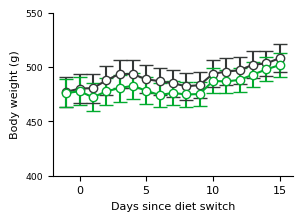

In [30]:
fig = plt.figure(figsize=(3.2,2.4))
ax = plt.subplot(1,1,1)
np_mean.plot(yerr=np_sem, color='xkcd:charcoal', marker='o', markerfacecolor='white')
lp_mean.plot(yerr=lp_sem, color='xkcd:kelly green', marker='o', markerfacecolor='white')
ax.set_ylim([400, 550])
ax.set_xlim([-1, 17])
plt.xticks([1,6,11,16], ('0', '5', '10', '15'))
plt.yticks([400, 450, 500, 550])
ax.set_ylabel('Body weight (g)')
ax.set_xlabel('Days since diet switch')

### Stats on body weight

In [31]:
if statson == True:
    data = pd.read_csv(metafile, index_col=['rat', 'diet'])

    data = data[:].stack()
    data = data.to_frame()
    data.reset_index(inplace=True) 
    data.columns = ['rat', 'diet', 'day', 'licks']
    ro.globalenv['r_data'] = data

    ro.r('bodyweight = aov(formula = licks ~ day * diet + Error(rat / day), data = r_data)')

    print(ro.r('summary(bodyweight)'))

### Figure 1B - Food intake

(0, 35)

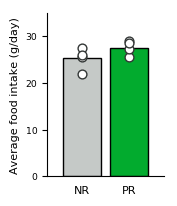

In [32]:
foodintake_np = [22.0, 25.6, 27.6, 26.1]
foodintake_lp = [25.5, 27.3, 29.1, 28.5]

foodintake_npAll = [22.0, 25.6, 27.6, 26.1, 22.9, 21.0, 21.3, 20.6]
foodintake_lpAll = [25.5, 27.3, 29.1, 28.5, 27.4, 29.9, 23.5, 26.3]

fi = data2obj1D([foodintake_np, foodintake_lp])
#fi = np.array([foodintake_np, foodintake_lp],
#         dtype='object')
mpl.rcParams['figure.subplot.left'] = 0.25
fig = plt.figure(figsize=(1.8,2.4))
ax = plt.subplot(1,1,1)
barscatter(fi, barfacecoloroption='individual',
                 barwidth = 0.8,
                 barfacecolor = ['xkcd:silver', 'xkcd:kelly green'],
                 scatteredgecolor = ['xkcd:charcoal'],
                 scattersize = 40,
                 ylabel = 'Average food intake (g/day)',
                 grouplabel=['NR', 'PR'],
                 ax=ax)
plt.yticks([0, 10, 20, 30])
ax.set_xlim([0.25,2.75])
ax.set_ylim([0, 35])

(0, 35)

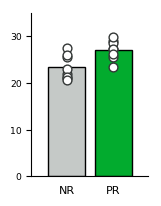

In [33]:
fi = data2obj1D([foodintake_npAll, foodintake_lpAll])
fig = plt.figure(figsize=(1.8,2.4))
ax = plt.subplot(1,1,1)
barscatter(fi, barfacecoloroption='individual',
                 barwidth = 0.8,
                 barfacecolor = ['xkcd:silver', 'xkcd:kelly green'],
                 scatteredgecolor = ['xkcd:charcoal'],
                 scattersize = 40,
                 grouplabel=['NR', 'PR'],
                 ax=ax)
plt.yticks([0, 10, 20, 30])
ax.set_xlim([0.25,2.75])
ax.set_ylim([0, 35])

### Stats on food intake

In [34]:
if statson == True:
    mpl.rcParams['figure.subplot.left'] = 0.15
    fi_stats = stats.ttest_ind(foodintake_npAll, foodintake_lpAll)
    print(fi_stats)

## Assemble conditioning data

In [54]:
dfc1 = pd.DataFrame([(rats[x].casein1) for x in rats])
dfc2 = pd.DataFrame([(rats[x].casein2) for x in rats])
dfm1 = pd.DataFrame([(rats[x].maltodextrin1) for x in rats])
dfm2 = pd.DataFrame([(rats[x].maltodextrin2) for x in rats])

for df in [dfc1, dfc2, dfm1, dfm2]:
    df.insert(0,'ratid', [x for x in rats])
    df.insert(1,'diet', [rats[x].diet for x in rats])

df = pd.concat([dfc1, dfc2, dfm1, dfm2])

df.insert(2,'sol',['c']*48 + ['m']*48)
df.insert(3,'day',['c1']*24 + ['c2']*24 + ['m1']*24 + ['m2']*24)

df2 = df[['ratid', 'diet']][:48]
casall = df[df['day'] == 'c1']['total'] + df[df['day'] == 'c2']['total']
maltall = df[df['day'] == 'm1']['total'] + df[df['day'] == 'm2']['total']

df2.insert(2,'sol',['c']*24 + ['m']*24)
df2.insert(3,'total', casall.append(maltall))

## Figure for individual conditioning days - histograms

In [66]:
def condhistFig(ax, df, factor, sol='maltodextrin'):
    if sol == 'casein':
        NRcolor = 'black'
        PRcolor = 'xkcd:kelly green'
    else:
        NRcolor = 'xkcd:silver'
        PRcolor = 'xkcd:light green'
        
    dietmsk = df.diet == 'np'

    shadedError(ax, df[factor][dietmsk], linecolor=NRcolor)
    ax = shadedError(ax, df[factor][~dietmsk], linecolor=PRcolor)
    ax.set_xticks([0,10,20,30])
    ax.set_xticklabels(['0', '20', '40', '60'])


In [86]:
def cond2Dfig(ax, df, factor, sol='maltodextrin'):
    if sol == 'casein':
        day1msk = df.day == 'c1'
        day2msk = df.day == 'c2'
    else:
        day1msk = df.day == 'm1'
        day2msk = df.day == 'm2'
        
    dietmsk = df.diet == 'np'
   
    a = [[df[factor][day1msk & dietmsk], df[factor][day2msk & dietmsk]],
          [df[factor][day1msk & ~dietmsk], df[factor][day2msk & ~dietmsk]]]

    x = data2obj2D(a)
    
    if sol == 'casein':
        barfacecolor = [col['np_cas'], col['np_cas'], col['lp_cas'], col['lp_cas']]
    else:
        barfacecolor = [col['np_malt'], col['np_malt'], col['lp_malt'], col['lp_malt']]
        
    ax, x, _, _ = barscatter(x, paired=True,
                 barfacecoloroption = 'individual',
                 barfacecolor = barfacecolor,
                 scatteredgecolor = ['xkcd:charcoal'],
                 scatterlinecolor = 'xkcd:charcoal',
                 grouplabel=['NR', 'PR'],
                 scattersize = 60,
                 ax=ax)

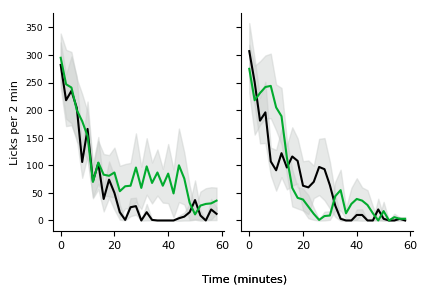

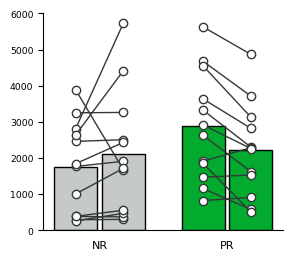

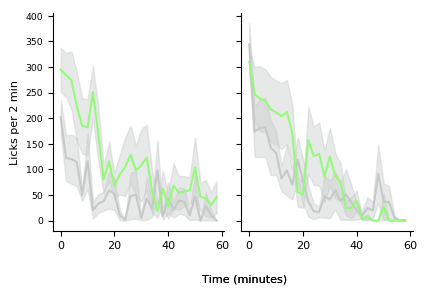

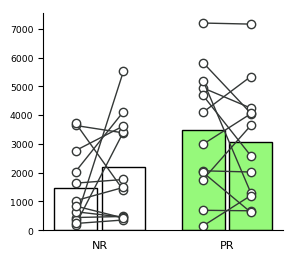

In [90]:
mpl.rcParams['figure.subplot.wspace'] = 0.1
mpl.rcParams['figure.subplot.left'] = 0.15
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(4.8, 3.2))

condhistFig(ax[0], dfc1, 'hist', sol='casein')
fig.text(0.55, 0.04, 'Time (minutes)', ha='center')
ax[0].set_ylabel('Licks per 2 min')

condhistFig(ax[1], dfc2, 'hist', sol='casein')
fig.text(0.55, 0.04, 'Time (minutes)', ha='center')

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(3.2, 3.2))
cond2Dfig(ax, df, 'total', sol='casein')

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(4.8, 3.2))
condhistFig(ax[0], dfm1, 'hist')
fig.text(0.55, 0.04, 'Time (minutes)', ha='center')
ax[0].set_ylabel('Licks per 2 min')

condhistFig(ax[1], dfm2, 'hist')
fig.text(0.55, 0.04, 'Time (minutes)', ha='center')

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(3.2, 3.2))
cond2Dfig(ax, df, 'total')

### Figure 2 - Licks during conditioning sessions

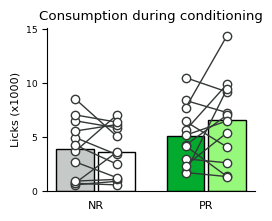

In [36]:
fig = plt.figure(figsize=(3.2, 2.4))
ax = plt.subplot(1,1,1)
nplp2Dfig(df2, 'total', ax=ax)
plt.yticks([0, 5000, 10000, 15000], ('0', '5', '10', '15'))
ax.set_ylabel('Licks (x1000)')
#plt.savefig('ADD FILEPATH/03_condlicks.eps')
plt.title('Consumption during conditioning')

### Stats on conditioning days

In [37]:
if statson == True:
    r_df = df2[['ratid', 'sol', 'diet', 'total']]
    ro.globalenv['r_df'] = r_df
    ro.r('condlicks = aov(formula = total ~ sol * diet + Error(ratid / sol), data = r_df)')
    print('Licks during conditioning')
    print(ro.r('summary(condlicks)'))

## Assemble data for preference day

In [38]:
dfc = pd.DataFrame([(rats[x].preference1_cas) for x in rats])
dfm = pd.DataFrame([(rats[x].preference1_malt) for x in rats])

for df in [dfc, dfm]:
    df.insert(0,'ratid', [x for x in rats])
    df.insert(1,'diet', [rats[x].diet for x in rats])
    
df = pd.concat([dfc, dfm])

df.insert(2,'sol',['c']*24 + ['m']*24)

df2 = df[['ratid', 'diet']][:24]
pref = df.total[:24]/(df.total[:24]+df.total[24:])
df2.insert(2,'pref', pref)

### Figure 3A - histogram of licks over time

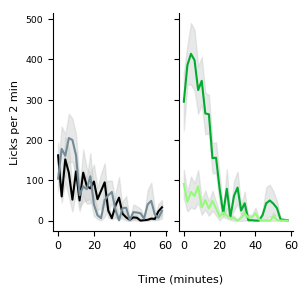

In [39]:
mpl.rcParams['figure.subplot.wspace'] = 0.1
mpl.rcParams['figure.subplot.left'] = 0.15
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(3.2, 3.2))

prefhistFig(ax[0], ax[1], df, 'hist')
fig.text(0.55, 0.04, 'Time (minutes)', ha='center')
ax[0].set_ylabel('Licks per 2 min')

### Figure 3B - casein licks vs maltodextrin licks

([<matplotlib.axis.YTick at 0xbd45a90>,
 <a list of 4 Text yticklabel objects>)

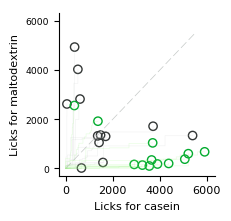

In [40]:
mpl.rcParams['figure.subplot.left'] = 0.25
fig = plt.figure(figsize=(2.4, 2.4))
ax = plt.subplot(1,1,1)                
casVmaltFig(ax, df)
ax.set_xlabel('Licks for casein')
ax.set_ylabel('Licks for maltodextrin')
plt.yticks([0, 2000, 4000, 6000])

### Figure 3C - total casein licks vs maltodextrin licks

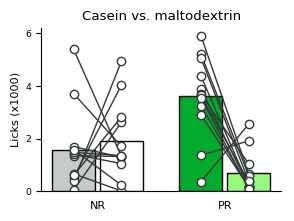

In [41]:
mpl.rcParams['figure.subplot.left'] = 0.15
fig = plt.figure(figsize=(3.2, 2.4))
ax = plt.subplot(1,1,1) 
nplp2Dfig(df, 'total', ax)
ax.set_ylabel('Licks (x1000)')
plt.yticks([0, 2000, 4000, 6000], ('0', '2', '4', '6'))
#plt.savefig('ADD FILE PATHER/06_preftotal.eps')
plt.title('Casein vs. maltodextrin')

### Stats on preference day (licks)

In [42]:
if statson == True:
    r_df = df[['ratid', 'sol', 'diet', 'total', 'bMean', 'bNum']]
    ro.globalenv['r_df'] = r_df

    ro.r('totallicks = aov(formula = total ~ sol * diet + Error(ratid / sol), data = r_df)')
    ro.r('burstMean = aov(formula = bMean ~ sol * diet + Error(ratid / sol), data = r_df)')
    ro.r('burstNum = aov(formula = bNum ~ sol * diet + Error(ratid / sol), data = r_df)')

    print('Total licks')
    print(ro.r('summary(totallicks)'))

In [43]:
if statson == True:
    ro.r('np_casvmalt = t.test(r_df$total[r_df$diet=="np" & r_df$sol=="c"], r_df$total[r_df$diet=="np" & r_df$sol=="m"], paired=TRUE)')
    print('Normal protein rats - casein vs. maltodextrin')
    print(ro.r('np_casvmalt'))

In [44]:
if statson == True:
    ro.r('lp_casvmalt = t.test(r_df$total[r_df$diet=="lp" & r_df$sol=="c"], r_df$total[r_df$diet=="lp" & r_df$sol=="m"], paired=TRUE)')
    print('LOW PROTEIN rats - casein vs. maltodextrin')
    print(ro.r('lp_casvmalt'))

## Analysis of Palatability

### Figure 4A - licks per cluster

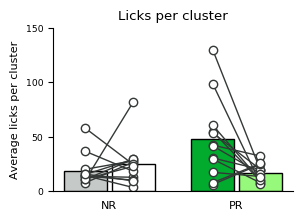

In [45]:
fig = plt.figure(figsize=(3.2, 2.4))
ax = plt.subplot(1,1,1)
nplp2Dfig(df, 'bMean', ax)
ax.set_ylabel('Average licks per cluster')
ax.set_yticks([0, 50, 100, 150])
#plt.savefig('ADD FILE PATHER/07_prefburstmean.eps')
plt.title('Licks per cluster')

### Figure 4B - number of clusters

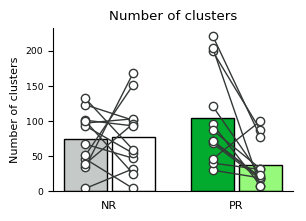

In [46]:
fig = plt.figure(figsize=(3.2, 2.4))
ax = plt.subplot(1,1,1)
nplp2Dfig(df, 'bNum', ax)
ax.set_ylabel('Number of clusters')
ax.set_yticks([0, 50, 100, 150, 200])
#plt.savefig('ADD FILE PATHER/08_prefburstnum.eps',
#            transparent=True)
plt.title('Number of clusters')

### Stats on preference day (palatability)

In [47]:
if statson == True:
    print('Licks per burst')
    print(ro.r('summary(burstMean)'))

    ro.r('np_casvmalt = t.test(r_df$bMean[r_df$diet=="np" & r_df$sol=="c"], r_df$bMean[r_df$diet=="np" & r_df$sol=="m"], paired=TRUE)')
    print('Normal protein rats (licks per burst) - casein vs. maltodextrin')
    print(ro.r('np_casvmalt'))

    ro.r('lp_casvmalt = t.test(r_df$bMean[r_df$diet=="lp" & r_df$sol=="c"], r_df$bMean[r_df$diet=="lp" & r_df$sol=="m"], paired=TRUE)')
    print('LOW PROTEIN rats (licks per burst) - casein vs. maltodextrin')
    print(ro.r('lp_casvmalt'))

### Stats on palatability (number of clusters)

In [48]:
if statson == True:
    print('Number of clusters')
    print(ro.r('summary(burstNum)'))

    ro.r('np_casvmalt = t.test(r_df$bNum[r_df$diet=="np" & r_df$sol=="c"], r_df$bNum[r_df$diet=="np" & r_df$sol=="m"], paired=TRUE)')
    print('Normal protein rats (number of clusters) - casein vs. maltodextrin')
    print(ro.r('np_casvmalt'))

    ro.r('lp_casvmalt = t.test(r_df$bNum[r_df$diet=="lp" & r_df$sol=="c"], r_df$bNum[r_df$diet=="lp" & r_df$sol=="m"], paired=TRUE)')
    print('LOW PROTEIN rats (number of clusters) - casein vs. maltodextrin')
    print(ro.r('lp_casvmalt'))

### Figure 3D - casein preference

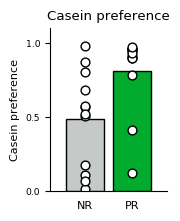

In [49]:
dietmsk = df2.diet == 'np'
a = data2obj1D([df2['pref'][dietmsk], df2['pref'][~dietmsk]])

mpl.rcParams['figure.subplot.left'] = 0.25
fig = plt.figure(figsize=(1.8, 2.4))
ax = plt.subplot(1,1,1)
barscatter(a, barfacecoloroption = 'between', barfacecolor = ['xkcd:silver', 'xkcd:kelly green'],
                     scatteredgecolor = ['black'],
                     scatterlinecolor = 'black',
                     grouplabel=['NR', 'PR'],
                     barwidth = 0.8,
                     scattersize = 40,
                     ylabel = 'Casein preference',
                     ax=ax)
ax.set_yticks([0, 0.5, 1.0])
ax.set_xlim([0.25,2.75])
ax.set_ylim([0, 1.1])
ax.set_ylabel('Casein preference')
#plt.savefig('ADD FILE PATHER/09_caseinpref.eps',
#            transparent=True)
plt.title('Casein preference')

### Stats on casein preference

In [50]:
if statson == True:
    ro.globalenv['nppref'] = df2[df2['diet'] == 'np']
    ro.globalenv['lppref'] = df2[df2['diet'] != 'np']

    ro.r('proteinPref = t.test(nppref[\'pref\'], lppref[\'pref\'], paired=FALSE)')
    print(ro.r('proteinPref'))